# PCA of Constant Maturity Treasury Rates – A Rolling Backtest Pipeline

In this notebook, we address a multi-part exercise that involves downloading constant maturity Treasury rate data, constructing a rolling backtest pipeline that uses Principal Component Analysis (PCA) to build a risk model, and finally exploring model parameters via grid search. Our study period is from January 1, 2001 to December 31, 2022 and the data is resampled to weekly frequency. We then extend scikit-learn's functionality by creating our own versions of TimeSeriesSplit and PCA classes.

The notebook is organized as follows:

1. Data Preparation: Download and preprocess daily Treasury rates ( 10 series) and resample them to weekly frequency.

2. RolledTimeSeriesSplit: Create an extension of scikit-learn's TimeSeriesSplit that limits the training window according to a specified ratio.

3. MyPCA Class: Extend scikit-learn's PCA so that it accepts a DataFrame (indexed by date) and provides a plotting function for the components.

4. Pipeline Construction: Build a rolling backtest pipeline that first splits the data (using our RolledTimeSeriesSplit) and then applies our custom PCA.

5. Backtest Run (n_splits=22, n_components=1, train_test_ratio=5): Run the pipeline, observe the evolution of the explained variance ratio and the shape of the top factor, and comment on any significant changes over time.

6. Grid Search: Search over a grid of parameters (n_splits and train_test_ratio) while fixing n_components $=3$ to find the combination that explains the most variance; then plot the time evolution of the PCA components for the optimal model.

Let's now proceed step by step.

## 1. Data Preparation

**Objective:**

Download the daily constant maturity Treasury rates for 1 month, 3 month, 6 month, 1 year, 2 year, 3 year, 5 year, 10 year, 20 year, and 30 year from FRED, restrict to the period from 2001-2022, combine into a single DataFrame, resample to weekly frequency (to obtain 1144 datapoints), and save the result as prices.csv.

**Explanation:**

We use pandas_datareader to fetch data from FRED. The FRED series codes are as follows:

- 1 month: DGS1MO

- 3 month: DGS3MO

- 6 month: DGS6MO

- 1 year: DGS1

- 2 year: DGS2

- 3 year: D6S3

- 5 year: DGS5

- 10 year: DCS10

- 20 year: DGS20

- 30 year: DGS30

After downloading, we join the series into a DataFrame, filter the dates, resample to weekly frequency (taking the last available rate in each week), and save the data.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# For data download; install via pip install pandas_datareader if needed
import pandas_datareader.data as web

# Define the series codes for constant maturity Treasury rates
series_codes = {
    '1M': 'DGS1MO',
    '3M': 'DGS3MO',
    '6M': 'DGS6MO',
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '3Y': 'DGS3',
    '5Y': 'DGS5',
    '10Y': 'DGS10',
    '20Y': 'DGS20',
    '30Y': 'DGS30'
}

# Define the date range
start_date = '2001-01-01'
end_date = '2022-12-31'

# Create an empty DataFrame for the rates
rates_df = pd.DataFrame()

# Loop through each series, download the data, and merge into a single DataFrame as desired
for label, code in series_codes.items():
    try:
        df = web.DataReader(code, 'fred', start_date, end_date)
        df.rename(columns={code: label}, inplace=True)
        if rates_df.empty:
            rates_df = df
        else:
            rates_df = rates_df.join(df, how='outer')
    except Exception as e:
        print(f"Error downloading {code}: {e}")

# Drop rows with all missing values and sort by date
rates_df.dropna(how='all', inplace=True)
rates_df.sort_index(inplace=True)

# Resample to weekly frequency (we take the last available observation in each week)
rates_weekly = rates_df.resample('W-FRI').last()  # using Friday as week-end

# Optionally, fill missing values with the mean of each column
rates_weekly = rates_weekly.fillna(rates_weekly.mean())

print("Weekly rates shape:", rates_weekly.shape)  # Expecting ~1144=22*52 datapoints
rates_weekly.head()

# Save the DataFrame to a CSV file
rates_weekly.to_csv('prices.csv')

Weekly rates shape: (1148, 10)


## 2. Implementing `RolledTimeSeriesSplit`

**Objective:**

Extend scikit-learn's `TimeSeriesSplit` class by implementing a `RolledTimeSeriesSplit` that takes an extra parameter `train_test_ratio`. When set to None, the split behaves like the standard expanding window; otherwise, the training window stops expanding once its length exceeds

$$
\text { floor(train\_test\_ratio $\times$ len(test\_index)) }
$$

In that case, we only use the most recent observations (i.e., "rolling") in the training set.

**Explanation:**

We subclass `TimeSeriesSplit` and override its `split()` method. In each split, if `train_test_ratio` is provided and the size of the training set exceeds the threshold, we restrict the training indices to the most recent `floor(train_test_ratio * len(test_index))` observations.

In [36]:
from sklearn.model_selection import TimeSeriesSplit

class RolledTimeSeriesSplit(TimeSeriesSplit):
    # Set n_split as default to 5, room for parameter tuning
    def __init__(self, n_splits=5, train_test_ratio=None):
        super().__init__(n_splits=n_splits)
        self.train_test_ratio = train_test_ratio

    # Rewrite the split method to include the train_test_ratio parameter
    def split(self, X, y=None, groups=None):
        # Use the base class splitting mechanism
        for train_index, test_index in super().split(X, y, groups):
            if self.train_test_ratio is not None:
                # Compute maximum training window size
                max_train_size = int(np.floor(self.train_test_ratio * len(test_index)))
                if len(train_index) > max_train_size:
                    # Keep only the most recent observations in the training set
                    train_index = train_index[-max_train_size:]
            yield train_index, test_index

# Example usage and comparison:
print('TimeSeriesSplit: ')

ts = TimeSeriesSplit(n_splits=7)
for train_idx, test_idx in ts.split(rates_weekly):
    print("Train indices length:", len(train_idx), "Test indices length:", len(test_idx))

print('\nRolledTimeSeriesSplit: ')

rts = RolledTimeSeriesSplit(n_splits=7, train_test_ratio=5)
for train_idx, test_idx in rts.split(rates_weekly):
    print("Train indices length:", len(train_idx), "Test indices length:", len(test_idx))


TimeSeriesSplit: 
Train indices length: 147 Test indices length: 143
Train indices length: 290 Test indices length: 143
Train indices length: 433 Test indices length: 143
Train indices length: 576 Test indices length: 143
Train indices length: 719 Test indices length: 143
Train indices length: 862 Test indices length: 143
Train indices length: 1005 Test indices length: 143

RolledTimeSeriesSplit: 
Train indices length: 147 Test indices length: 143
Train indices length: 290 Test indices length: 143
Train indices length: 433 Test indices length: 143
Train indices length: 576 Test indices length: 143
Train indices length: 715 Test indices length: 143
Train indices length: 715 Test indices length: 143
Train indices length: 715 Test indices length: 143


**Discussion of Results:**

In classical `TimeSeriesSplit`, in each fold, the training set grows; for example, the first split uses 147 samples for training, the second uses 290=147+143, the third 433, and so on. This pattern is known as an expanding window approach. The expanding window is often used in time series analysis to mimic a real-world scenario where, over time, you accumulate more data. However, one key drawback is that as the training set grows larger, it may incorporate outdated information that no longer reflects the current dynamics of the series.

In our customized `RolledTimeSeriesSplit`, in the first four splits, the training set lengths (147, 290, 433, and 576) match those of the standard expanding window. But beginning with the fifth split, instead of expanding further (which would normally reach 719 samples in the standard split), the training set is capped at 715 samples. The cap is determined by the parameter train_test_ratio. In this example, with a train_test_ratio of 5 and a fixed test set length of 143 , the maximum allowed training set size is calculated as:

$$
\max \text { train\_size }=\text { floor }(5 \times 143)=715
$$

After reaching this cap, the training window "rolls" forward: newer observations enter the training set while the oldest ones are dropped. This represents a rolling window approach where only the most recent data (up to a fixed number) is used for model training.

## 3. Implementing MyPCA

**Objective:**

Extend scikit-learn's PCA class by creating a MyPCA class. Its fit() method should accept a DataFrame indexed by date. Additionally, implement a plot_components() method that plots the PCA components as a function of the original feature index (i.e., the column index of the DataFrame). The plot title must include the explained_variance_ratio_. A boolean parameter plot (default False) in the fit() method should trigger plotting when set to True .

**Explanation:**

By subclassing PCA, we add functionality to handle DataFrame inputs (storing the feature names for later reference) and to plot the components. The plot will display the loadings for each component over the features and annotate the plot with the explained variance ratio.

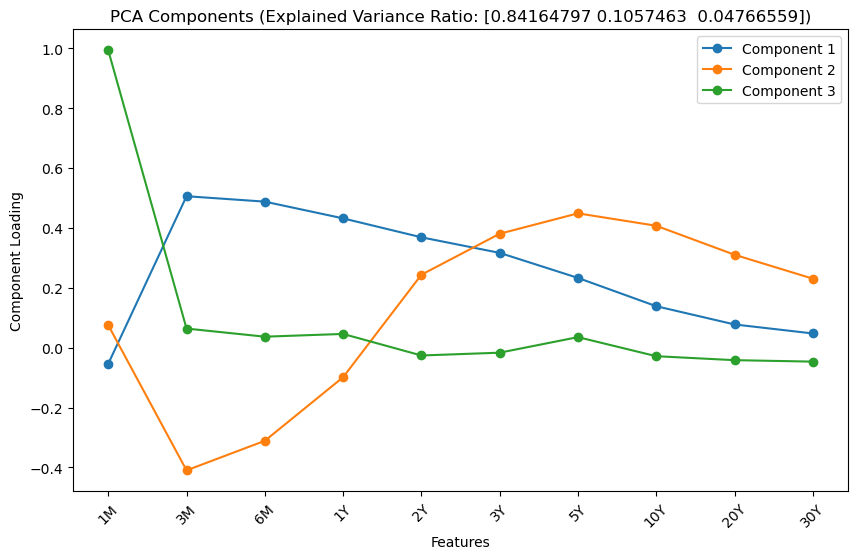

MyPCA(n_components=3)

In [37]:
from sklearn.decomposition import PCA

class MyPCA(PCA):
    def __init__(self, n_components=None, **kwargs):
        super().__init__(n_components=n_components, **kwargs)
        self.feature_names_ = None
        self.index_ = None  # To store the time index

    def fit(self, X, y=None, plot=False):
        """
        Fit the PCA model on X.
        If X is a DataFrame, store its column features and time index.
        If plot==True, plot the PCA components.
        """
        if isinstance(X, pd.DataFrame):
            self.feature_names_ = X.columns.tolist()
            self.index_ = X.index  # Preserve the time index
            X_values = X.values
        else:
            X_values = X
        super().fit(X_values)
        if plot:
            self.plot_components()
        return self

    def plot_components(self):
        """
        Plot the PCA components as a function of the feature index.
        The plot title includes the explained variance ratio.
        """
        n_components = self.components_.shape[0]
        plt.figure(figsize=(10, 6))
        for i in range(n_components):
            if self.feature_names_ is not None:
                x = range(len(self.feature_names_))
                plt.plot(x, self.components_[i, :], marker='o', label=f'Component {i+1}')
                plt.xticks(range(len(self.feature_names_)), self.feature_names_, rotation=45)
            else:
                x = range(self.components_.shape[1])
                plt.plot(x, self.components_[i, :], marker='o', label=f'Component {i+1}')
    
        plt.xlabel('Features')
        plt.ylabel('Component Loading')
        plt.title(f'PCA Components (Explained Variance Ratio: {self.explained_variance_ratio_})')
        plt.legend()
        plt.show()
        
    ## Something we can do with the time index
    
    # def transform(self, X):
    #     """
    #     Transform X using the fitted PCA model.
    #     If X is a DataFrame, returns a DataFrame with the same index.
    #     """
    #     X_transformed = super().transform(X if not isinstance(X, pd.DataFrame) else X.values)
    #     if isinstance(X, pd.DataFrame):
    #         pc_columns = [f'PC{i+1}' for i in range(self.n_components_)]
    #         return pd.DataFrame(X_transformed, index=X.index, columns=pc_columns)
    #     return X_transformed

    # def plot_transformed(self, X_transformed):
    #     """
    #     Plot the time series of the transformed PCA data.
    #     X_transformed is assumed to be a DataFrame with the same time index as the input.
    #     """
    #     plt.figure(figsize=(10, 6))
    #     for col in X_transformed.columns:
    #         plt.plot(X_transformed.index, X_transformed[col], marker='o', label=col)
    #     plt.xlabel('Time')
    #     plt.ylabel('Principal Component Value')
    #     plt.title('PCA Transformed Time Series')
    #     plt.legend()
    #     plt.show()


# Example usage:
# Suppose we take a subset of our weekly rates.
sample_df = rates_weekly.iloc[:100]
mypca = MyPCA(n_components=3)
mypca.fit(sample_df, plot=True)
# transformed_data = mypca.transform(rates_weekly)
# mypca.plot_transformed(transformed_data)

**Discussion of Results:**

We can see that in our sampled (size of 100) data, the principal component obtains the significant 0.84 explained variance ratio, and the feature `3M` has the biggest loading/weight of around 0.5. 

# 4. Constructing the Rolling Backtest Pipeline

**Objective:**

Create a pipeline that initially performs a `RolledTimeSeriesSplit` followed by `MyPCA`. The pipeline's parameters include the number of PCA components ( `n_components` ), the number of splits ( `n\_splits` ), and the `train_test_ratio` for the time series split.

**Explanation:**

Since a pipeline in scikit-learn typically chains transformers and estimators (and the splitting procedure is handled separately via cross-validation), we here build a custom backtest function that, for each split produced by our `RolledTimeSeriesSplit`, fits a `MyPCA` model on the training data and (optionally) transforms the test data. This will allow us to record the evolution of the top PCA factor and its explained variance ratio over time.

In [38]:
def rolling_pca_backtest(data, n_components=1, n_splits=5, train_test_ratio=None, plot=False):
    """
    Perform a rolling backtest where for each split defined by RolledTimeSeriesSplit,
    we fit a MyPCA model on the training data. 
    
    Parameters:
        data: DataFrame indexed by date.
        n_components: Number of PCA components.
        n_splits: Number of splits for the rolling window.
        train_test_ratio: Ratio controlling the maximum training window size.
        plot: If True, plot all splits together in one figure as subplots.
        
    Returns:
        results: A list of dictionaries containing the split index, 
                 the explained variance ratio, and the PCA component matrix.
    """
    results = []
    rts = RolledTimeSeriesSplit(n_splits=n_splits, train_test_ratio=train_test_ratio)
    split_number = 1
    for train_idx, test_idx in rts.split(data):
        train_data = data.iloc[train_idx]
        # Fit MyPCA on the training data without calling its internal plotting
        mypca = MyPCA(n_components=n_components)
        mypca.fit(train_data, plot=False)
        
        # Record the explained variance ratio and the PCA components
        result = {
            'split': split_number,
            'explained_variance_ratio': mypca.explained_variance_ratio_,
            'components': mypca.components_,
            'feature_names': mypca.feature_names_  # preserved feature names (if available)
        }
        results.append(result)
        split_number += 1

    # If plot is True, display all splits' PCA component loadings in one consolidated figure
    if plot:
        n_plots = len(results)
        # Determine grid dimensions (here we choose 3 columns; adjust as needed)
        n_cols = 3
        n_rows = int(np.ceil(n_plots / n_cols))
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), squeeze=False)
        for i, res in enumerate(results):
            ax = axes[i // n_cols][i % n_cols]
            for comp_index in range(n_components):
                # Prepare x-axis data: if feature names are available, use their indices and labels
                if res['feature_names'] is not None:
                    x = range(len(res['feature_names']))
                    ax.plot(x, res['components'][comp_index, :], marker='o', 
                            label=f'Component {comp_index+1}')
                    ax.set_xticks(x)
                    ax.set_xticklabels(res['feature_names'], rotation=45, fontsize=8)
                else:
                    x = range(res['components'].shape[1])
                    ax.plot(x, res['components'][comp_index, :], marker='o', 
                            label=f'Component {comp_index+1}')
            ax.set_title(f'Split {res["split"]}\nEVR: {np.round(res["explained_variance_ratio"], 2)}', fontsize=10)
            ax.set_xlabel('Feature')
            ax.set_ylabel('Loading')
            ax.legend(fontsize=8)
        
        # Remove any unused axes (if n_plots is not a perfect multiple of n_cols)
        for j in range(i + 1, n_rows * n_cols):
            fig.delaxes(axes[j // n_cols][j % n_cols])
            
        plt.tight_layout()
        plt.show()

    return results

# 5. Backtest Run with Specific Parameters

**Objective:**

Run the pipeline for `n_splits=22`, `n_components=1`, and `train_test_ratio=5` with `plot=True`.
Document the observed periods where the explained variance ratio changes significantly, and plot the shape of the top factor/component through the backtest.

**Explanation:**

For each split, we will record the explained variance ratio and the top PCA component (the eigenvector corresponding to the single component). Then we can plot:

- The time series (across splits) of the explained variance ratio.

- A heatmap showing how the top factor's loadings (across the 10 features, maturities) evolve over time.

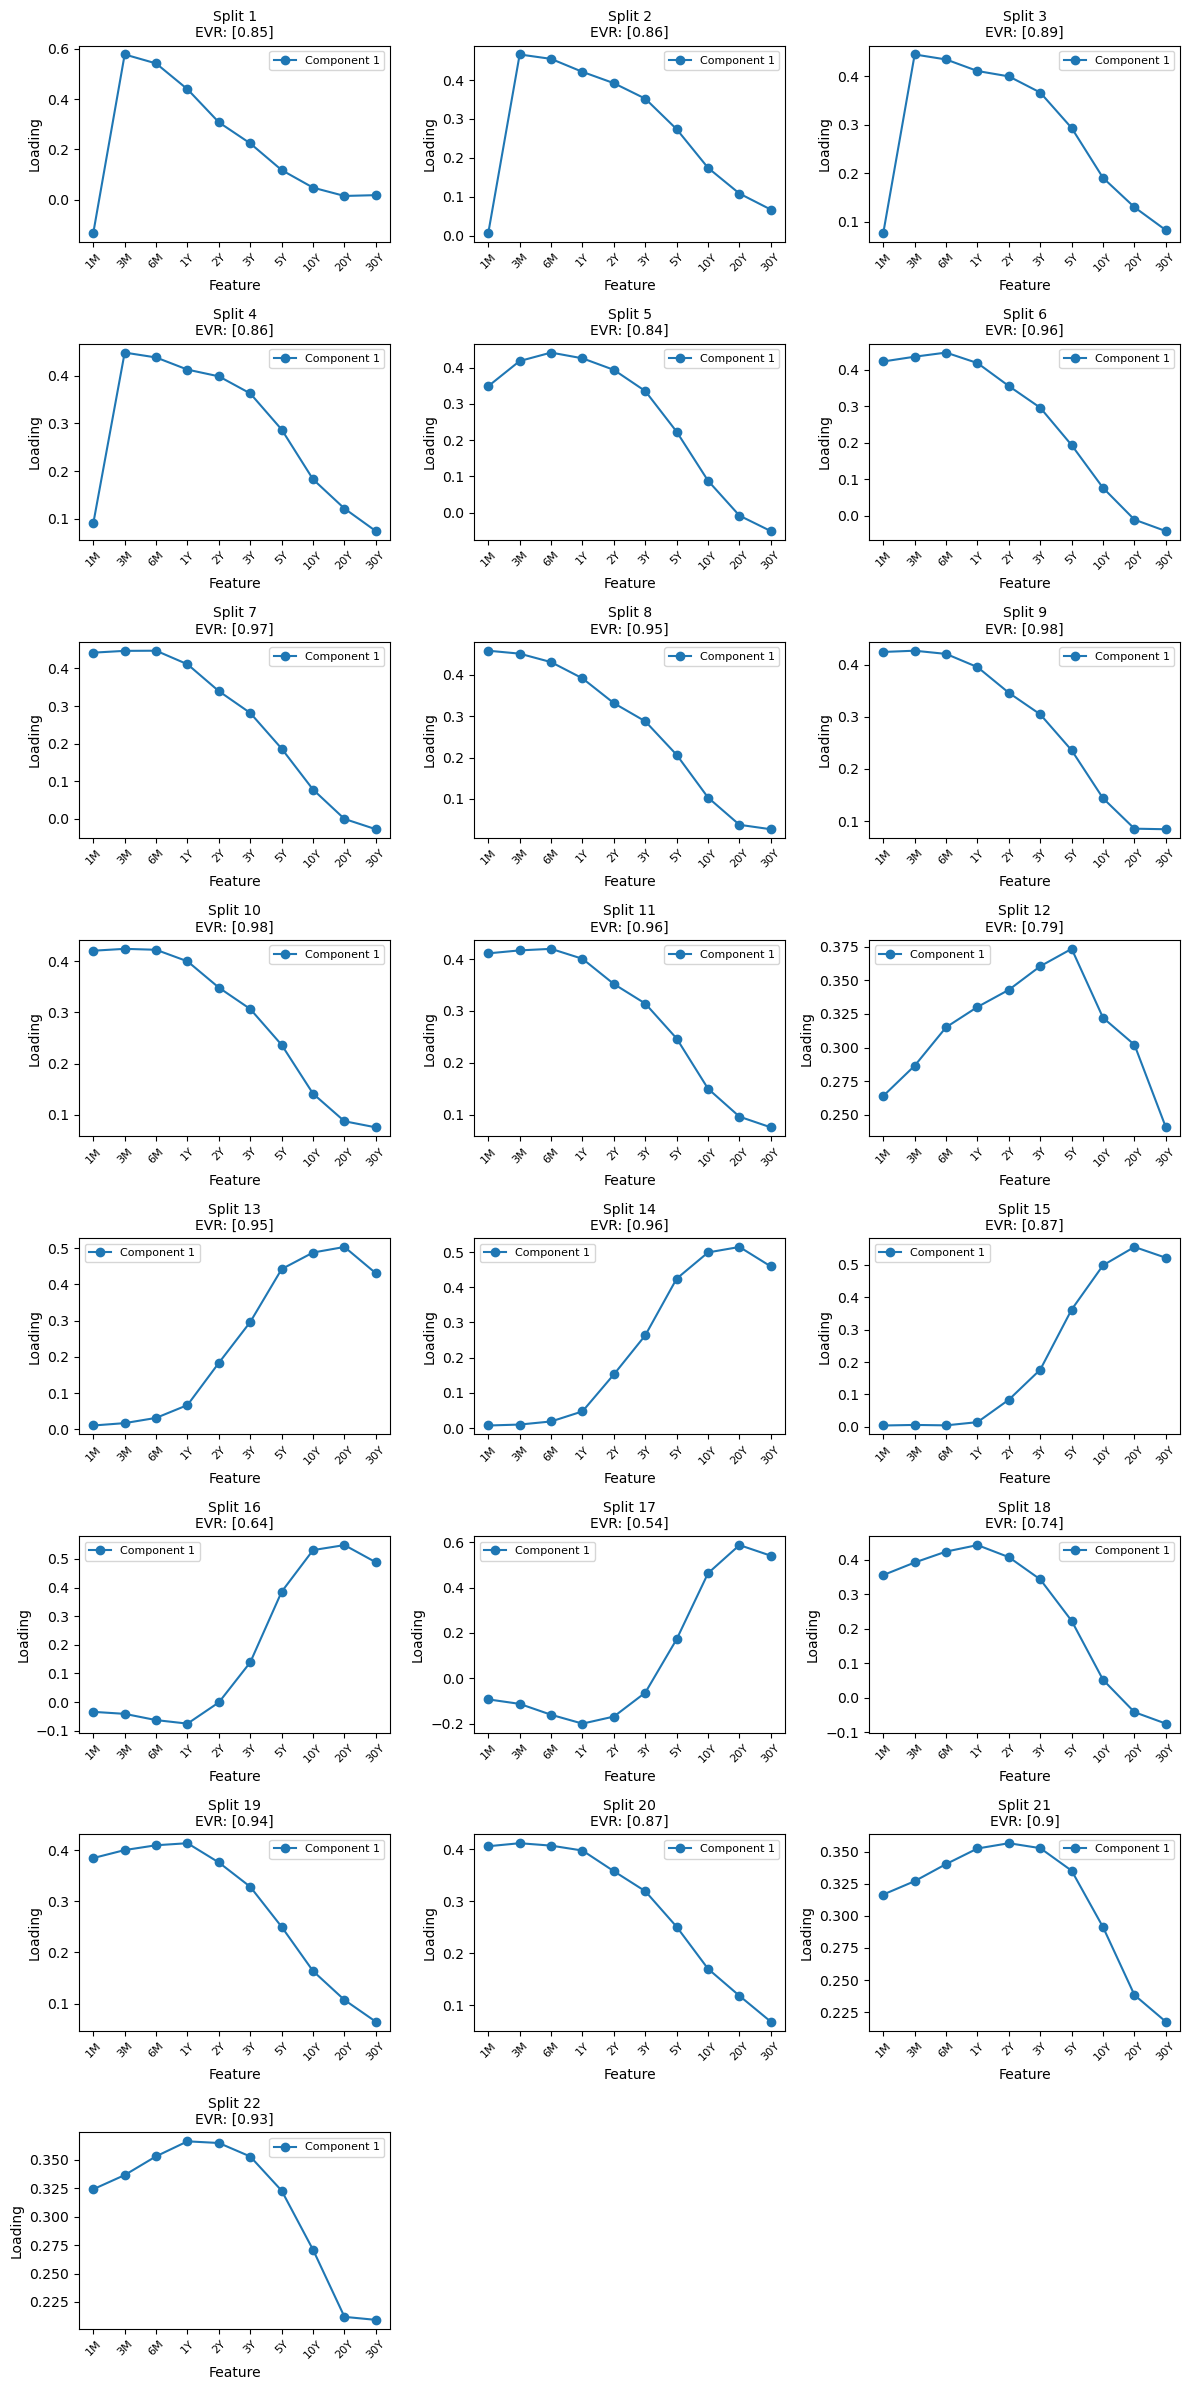

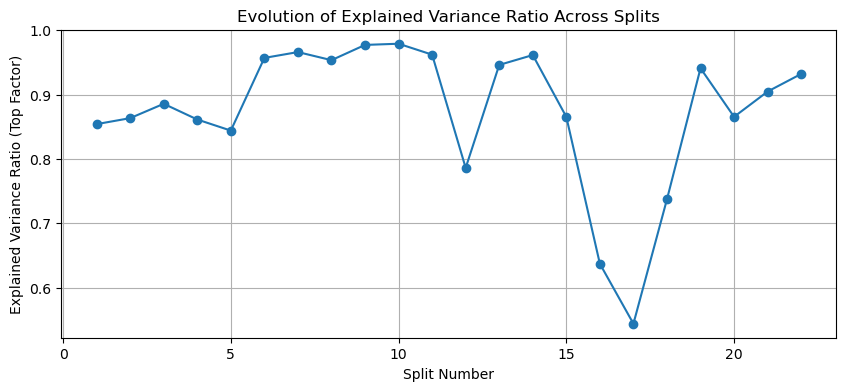

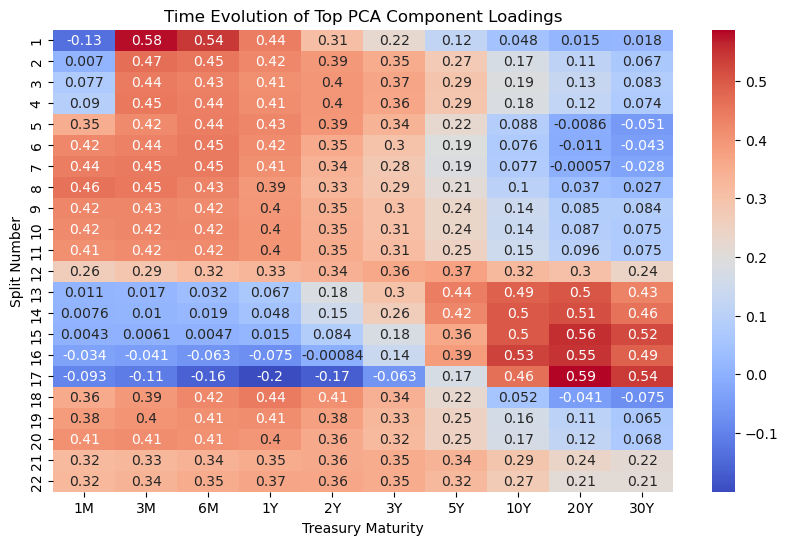

In [39]:
n_splits = 22
n_components = 1
train_test_ratio = 5

results = rolling_pca_backtest(rates_weekly, n_components=n_components, 
                               n_splits=n_splits, train_test_ratio=train_test_ratio, plot=True)

# Extract the explained variance ratios and components from the results
evr_list = [res['explained_variance_ratio'][0] for res in results]  # since n_components=1
components_list = [res['components'][0] for res in results]  # each is a vector of length 10

# Plot the explained variance ratio over splits
plt.figure(figsize=(10, 4))
plt.plot(range(1, n_splits+1), evr_list, marker='o')
plt.xlabel('Split Number')
plt.ylabel('Explained Variance Ratio (Top Factor)')
plt.title('Evolution of Explained Variance Ratio Across Splits')
plt.grid(True)
plt.show()

# Plot the evolution of the top PCA factor (loadings) over splits as a heatmap.
components_array = np.array(components_list)  # shape: (n_splits, n_features)
plt.figure(figsize=(10, 6))
sns.heatmap(components_array, cmap='coolwarm', annot=True, 
            xticklabels=rates_weekly.columns, yticklabels=range(1, n_splits+1))
plt.xlabel('Treasury Maturity')
plt.ylabel('Split Number')
plt.title('Time Evolution of Top PCA Component Loadings')
plt.show()

**Discussion of Results**

For most splits, the top factor/principal component explains between ~0.85 and ~0.98 of the total variance, which reflects a stong dominance over most time periods. Around splits 12–13 and especially ~16–17, the EVR plummets to ~0.54–0.64. This indicates a period when the first principal component alone no longer captures as much of the yield curve’s variation, which implies that the data structure became more complex during the periods. By looking into the history, this could be caused by 2012 European Sovereign Debt Crisis, **Obama Presdency**, or 2016 Brexit Referendum, **Trump Presidency**. After split 17, the EVR climbs back up to ~0.90–0.94, suggesting that everything goes back to normal and PCA captures the principal component of strong dominance. 

In most splits (e.g., Splits 1–10, 19–22), the top factor loadings decrease steadily from short maturities (1M, 3M) to longer maturities (20Y, 30Y). This is the textbook “level factor,” meaning that if yields all move up or down together, that is the primary variation captured.

Around Splits ~15–17, we see a substantially different loading pattern, e.g., negative at the short end and positive at the long end—or vice versa. This suggests that the PCA algorithm is capturing a different dominant movement (or a mix of factors) during that time window. In some splits, the factor even appears “U-shaped” or “inverted,” which is not typical of a pure level factor.

The heatmap makes it obvious: the top factor changes sign or changes slope at certain splits, aligning with the same period where the EVR dips. Each cell’s color highlights whether that maturity is positively or negatively loading on the factor for each time window.

A traditional factor interpretation is that ordinarily, the first factor in yield‐curve PCA is “level,” the second is “slope,” and the third is “curvature.” Here, for most splits, the top factor is indeed “level‐like.” But during those “unusual” splits, the top factor morphs to incorporate slope‐type behavior or other features, which explains the shape shifts and the concurrent drop in EVR.

# 6. Grid Search over Parameters

**Objective:**

Perform a grid search over n_splits in [22, 44] and train_test_ratio in [2, 3, 4, 5] while fixing the number of PCA components to 3 . For each combination, record the average explained variance (across splits) and select the parameters that explain the most variance. Then, for the optimal model, plot the time evolution of the PCA components.

**Explanation:**

We loop over the grid of parameters. For each setting, we run our rolling backtest pipeline, compute the average explained variance ratio (summing over the 3 components), and store the results. Finally, we select the best parameters and plot the evolution of all 3 PCA components over the backtest period.

Running backtest with n_splits=22 and train_test_ratio=2
Average Explained Variance: 0.9950677026259019

Running backtest with n_splits=22 and train_test_ratio=3
Average Explained Variance: 0.9957146452664237

Running backtest with n_splits=22 and train_test_ratio=4
Average Explained Variance: 0.9957484025568263

Running backtest with n_splits=22 and train_test_ratio=5
Average Explained Variance: 0.9958676336339313

Running backtest with n_splits=44 and train_test_ratio=2
Average Explained Variance: 0.9933731205870951

Running backtest with n_splits=44 and train_test_ratio=3
Average Explained Variance: 0.9941510891061561

Running backtest with n_splits=44 and train_test_ratio=4
Average Explained Variance: 0.9949367413388456

Running backtest with n_splits=44 and train_test_ratio=5
Average Explained Variance: 0.9954251461258367

Best Parameters:
n_splits: 22
train_test_ratio: 5
Average Total Explained Variance: 0.9958676336339313


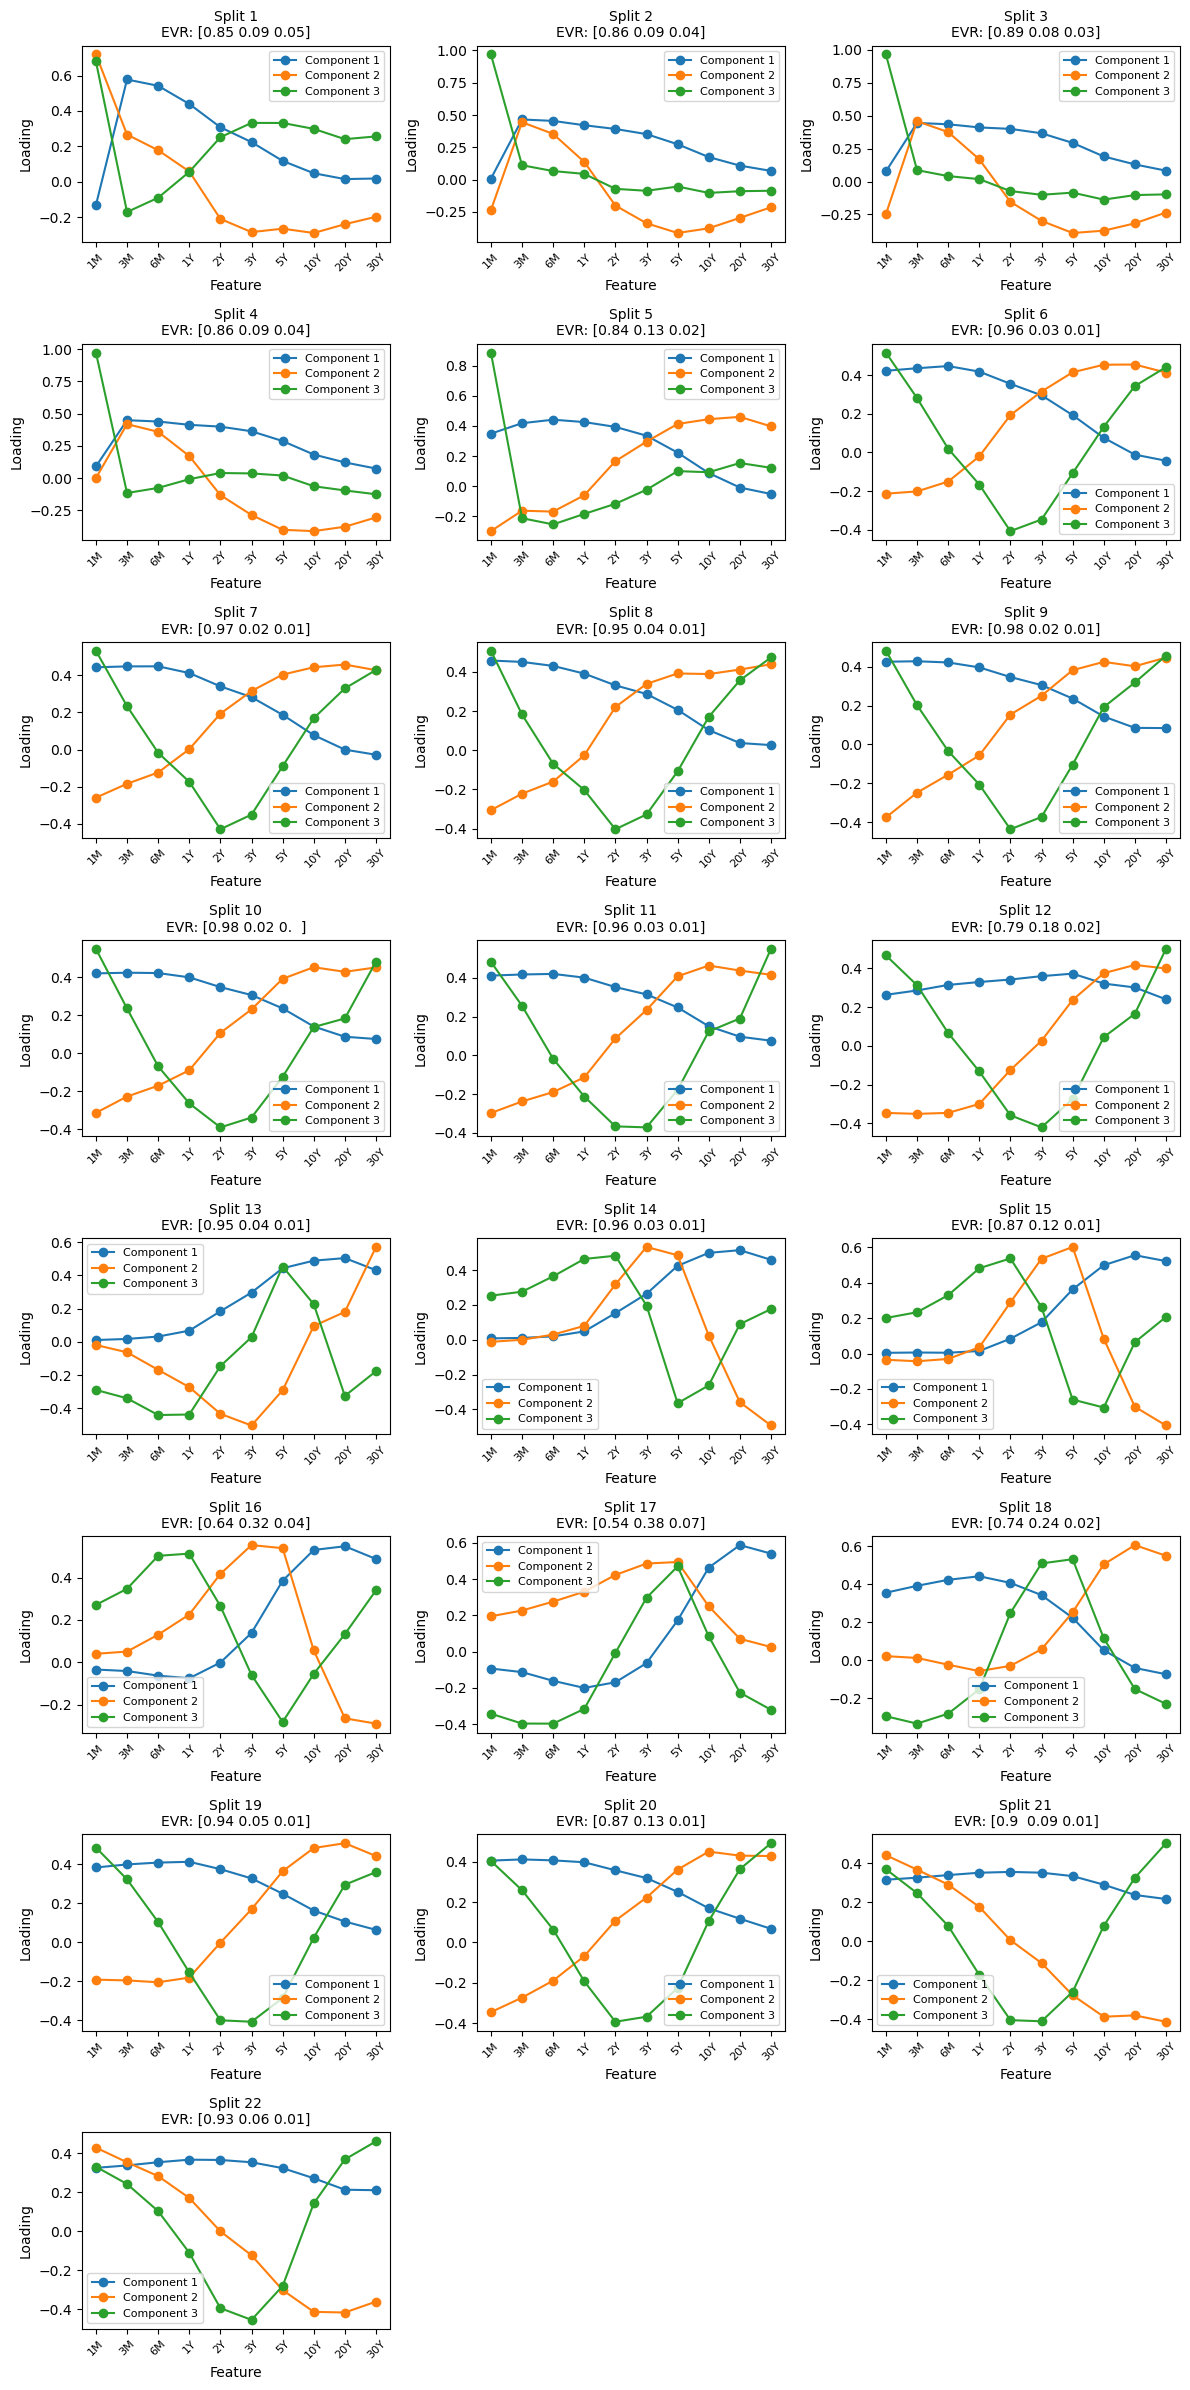

In [40]:
def custom_gridsearch(data, n_splits_list, train_test_ratio_list, n_components):
    """
    Perform a custom grid search over the parameters for the rolling PCA backtest.
    
    Parameters:
        data: DataFrame containing the time series data.
        n_splits_list: List of n_splits values to try.
        train_test_ratio_list: List of train_test_ratio values to try.
        n_components: Number of PCA components to use.
    
    Returns:
        grid_results: List of dictionaries containing the grid parameters, 
                      the average explained variance, and the full results.
    """
    grid_results = []
    for ns in n_splits_list:
        for ttr in train_test_ratio_list:
            print(f"Running backtest with n_splits={ns} and train_test_ratio={ttr}")
            grid_res = rolling_pca_backtest(data, n_components=n_components,
                                            n_splits=ns, train_test_ratio=ttr, plot=False)
            # Calculate the average total explained variance ratio (sum over components) across splits
            avg_total_explained_variance = np.mean([np.sum(res['explained_variance_ratio']) for res in grid_res])
            grid_results.append({
                'n_splits': ns,
                'train_test_ratio': ttr,
                'avg_total_explained_variance': avg_total_explained_variance,
                'results': grid_res
            })
            print(f"Average Explained Variance: {avg_total_explained_variance}\n")
    return grid_results

# Define the parameter grid
grid_n_splits = [22, 44]
grid_train_test_ratio = [2, 3, 4, 5]
n_components_fixed = 3

# Run the custom grid search
grid_results = custom_gridsearch(rates_weekly, grid_n_splits, grid_train_test_ratio, n_components_fixed)

# Find the best parameter combination based on the average explained variance
best_result = max(grid_results, key=lambda x: x['avg_total_explained_variance'])
print("Best Parameters:")
print("n_splits:", best_result['n_splits'])
print("train_test_ratio:", best_result['train_test_ratio'])
print("Average Total Explained Variance:", best_result['avg_total_explained_variance'])

results = rolling_pca_backtest(rates_weekly, n_components=n_components_fixed, 
                               n_splits=best_result['n_splits'], train_test_ratio=best_result['train_test_ratio'], plot=True)


## Final Remarks

In this notebook, we have:

- Constructed a weekly dataset of constant maturity Treasury rates from FRED over the period 2001-2022.

- Extended scikit-learn by implementing RolledTimeSeriesSplit to allow for a fixed-size (rolling) training window and MyPCA to fit and visualize PCA models on time series data.

- Built a rolling backtest pipeline that applies PCA on each training split to monitor the evolution of risk factors.

- Conducted experiments by running the pipeline with specified parameters and performing a grid search to optimize model performance.

- Analyzed the results, with particular attention to periods of significant changes in the explained variance ratio and shifts in the PCA component loadings over time.

This comprehensive solution demonstrates a robust approach to developing and backtesting PCAbased risk models for interest rate data.

---

End of Notebook